<a href="https://colab.research.google.com/github/hienvantran/CZ1015_FS4_project/blob/master/Copie_de_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pylab as plt
from math import ceil
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, ReLU, LeakyReLU, Dense
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.initializers import RandomNormal

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def build_generator(z_dim = 128, n_filter = 64):
    
    init = RandomNormal(stddev=0.02)
    
    G = Sequential()
    G.add(Dense(2*2*n_filter*8, input_shape=(z_dim,), use_bias=True, kernel_initializer=init))
    
    # 2*2*512
    G.add(Reshape((2,2,n_filter*8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 4*4*256
    G.add(Conv2DTranspose(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 8*8*128
    G.add(Conv2DTranspose(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 16*16*64
    G.add(Conv2DTranspose(n_filter, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 32*32*3
    G.add(Conv2DTranspose(3, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    
    print('Build Generator')
    print(G.summary())
    
    return G

In [0]:
def build_discriminator(input_shape=(32,32,3), n_filter=64):
    
    init = RandomNormal(stddev=0.02)
    
    D = Sequential()
    
    # 16*16*64
    D.add(Conv2D(n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(LeakyReLU(0.2))
    
    # 8*8*64
    D.add(Conv2D(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 4*4*64
    D.add(Conv2D(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 2*2*64
    D.add(Conv2D(n_filter*8, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    D.add(Flatten())
    D.add(Dense(1, kernel_initializer=init))
    D.add(Activation('sigmoid'))
    
    print('Build discriminator')
    print(D.summary())
    
    return D

In [0]:
def get_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    X_train = 2*(X_train/255)-1
    X_test = 2*(X_train/255)-1
    
    return X_train, X_test

In [0]:
def plot_images(images):
    h, w, c = images.shape[1:]
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images + 1) / 2. * 255.
    images = images.astype(np.uint8)
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imshow(images)
    plt.show()

In [0]:
def plot_losses(losses_d, losses_g):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    #plt.close()

In [0]:
def train(n_filter=64, z_dim=100, lr_d=2e-4, lr_g=2e-4, epochs = 300, batch_size = 128,
          epoch_per_checkpoint=1, n_checkpoint_images=36, verbose=10):
    X_train,_ = get_data()
    image_shape = X_train[0].shape
    print('Image shape {}, min val {}, max val {}'.format(image_shape, np.min(X_train[0]), np.max(X_train[0])))
    
    plot_images(X_train[:n_checkpoint_images])
    
    # Build model
    G = build_generator(z_dim, n_filter)
    D = build_discriminator(image_shape, n_filter)
    
    # Loss for discriminator
    D.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # D(G(X))
    D.trainable = False
    z = Input(shape=(z_dim,))
    D_of_G = Model(inputs=z, outputs=D(G(z)))
    
    # Loss for generator
    D_of_G.compile(Adam(lr=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # Labels for computing the losses
    real_labels = np.ones(shape=(batch_size, 1))
    fake_labels = np.zeros(shape=(batch_size, 1))
    losses_d, losses_g = [], []
    
    # fix a z vector for training evaluation
    z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
    
    for e in tqdm_notebook(range(1, epochs+1)):
        n_steps = X_train.shape[0]//batch_size
        for i in range(n_steps):
            # Train discriminator
            D.trainable = True
            real_images = X_train[i*batch_size:(i+1)*batch_size]
            loss_d_real = D.train_on_batch(x=real_images, y=real_labels)[0]
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            fake_images = G.predict_on_batch(z)
            loss_d_fake = D.train_on_batch(x=fake_images, y=fake_labels)[0]
            
            loss_d = loss_d_real + loss_d_fake
            
            # Train generator
            
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=real_labels)[0]
            
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            
            if i == 0 and e%verbose == 0:
                print('Epoch {}'.format(e))
                fake_images = G.predict(z_fixed)
                print("\tPlotting images and losses")
                plot_images(fake_images)
                plot_losses(losses_d, losses_g)

170500096/170498071 [==============================] - 4s 0us/step
Image shape (32, 32, 3), min val -1.0, max val 1.0


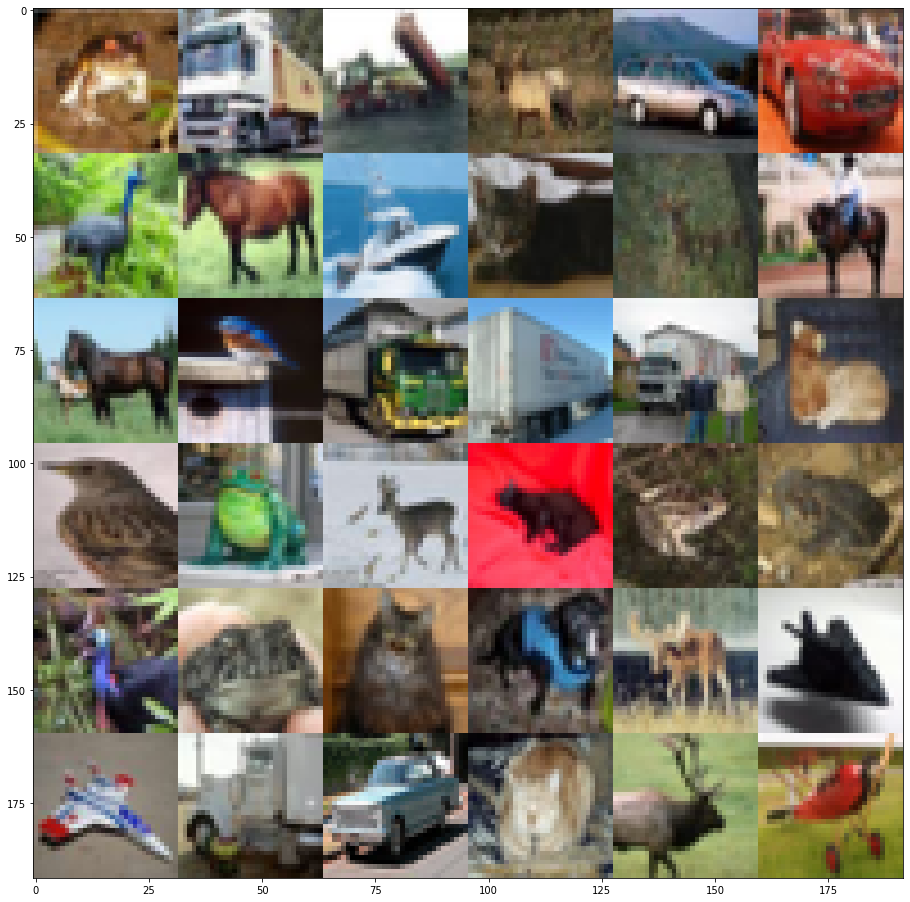

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Build Generator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_______________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 10
	Plotting images and losses


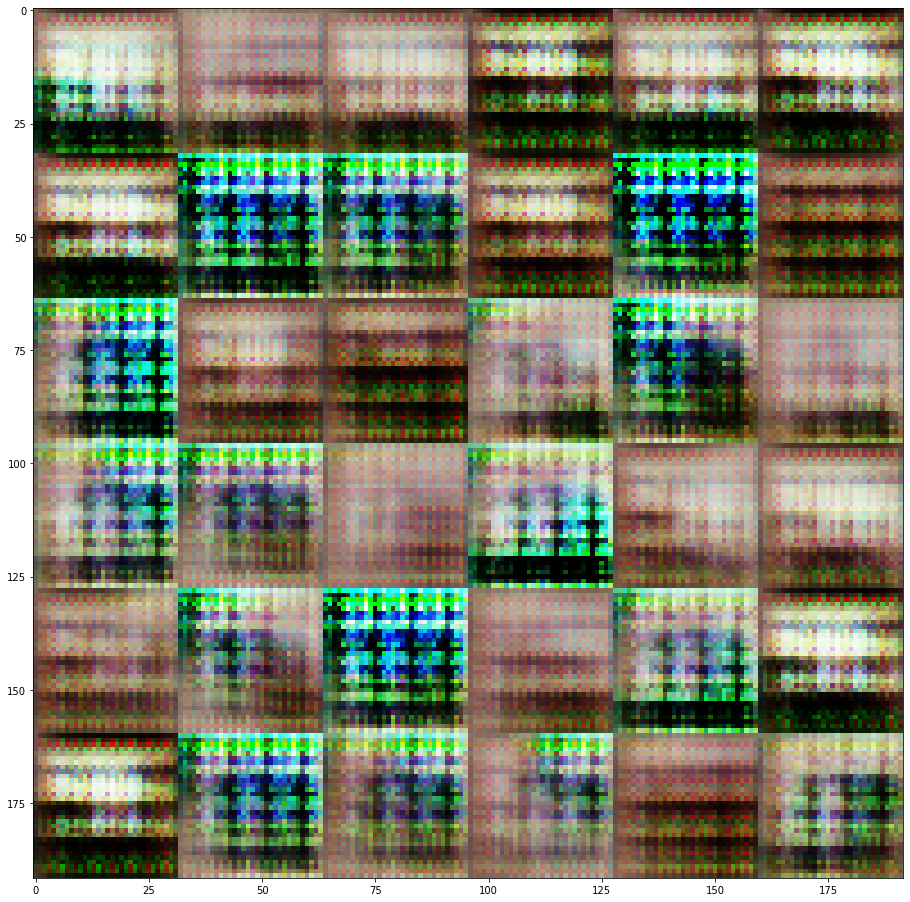

Epoch 20
	Plotting images and losses


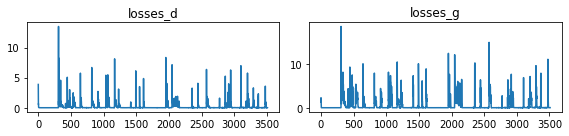

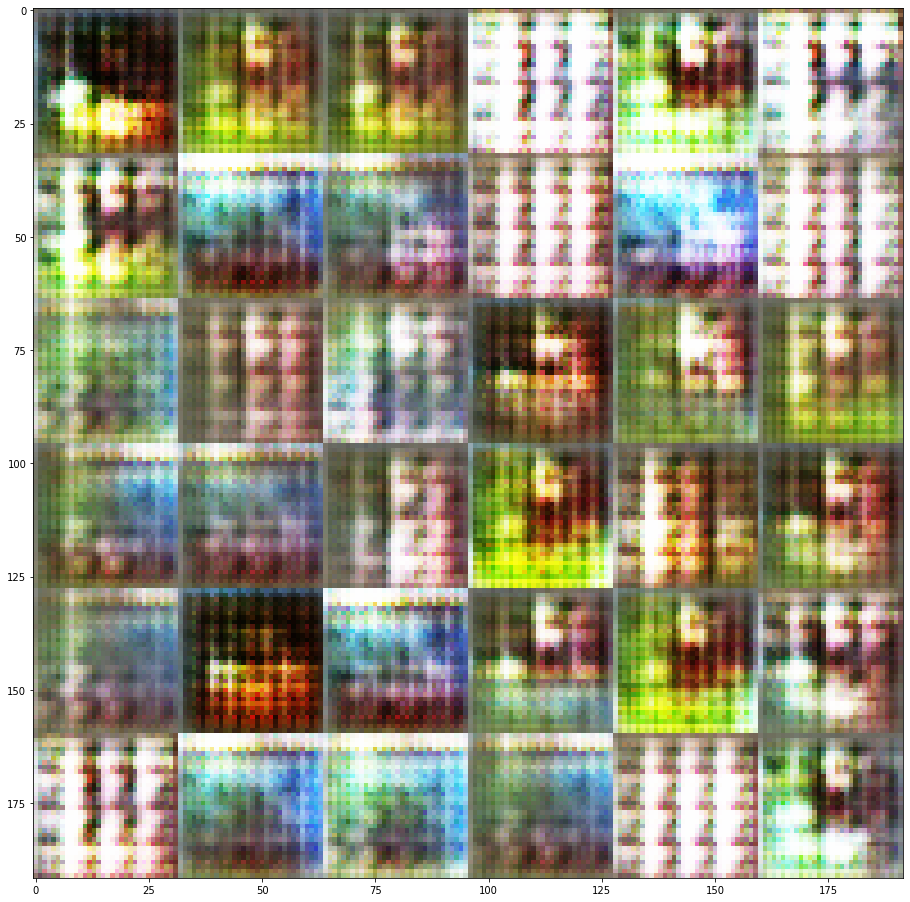

Epoch 30
	Plotting images and losses


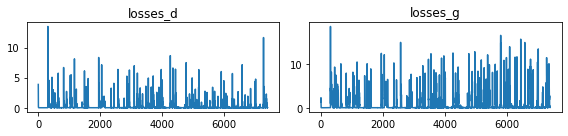

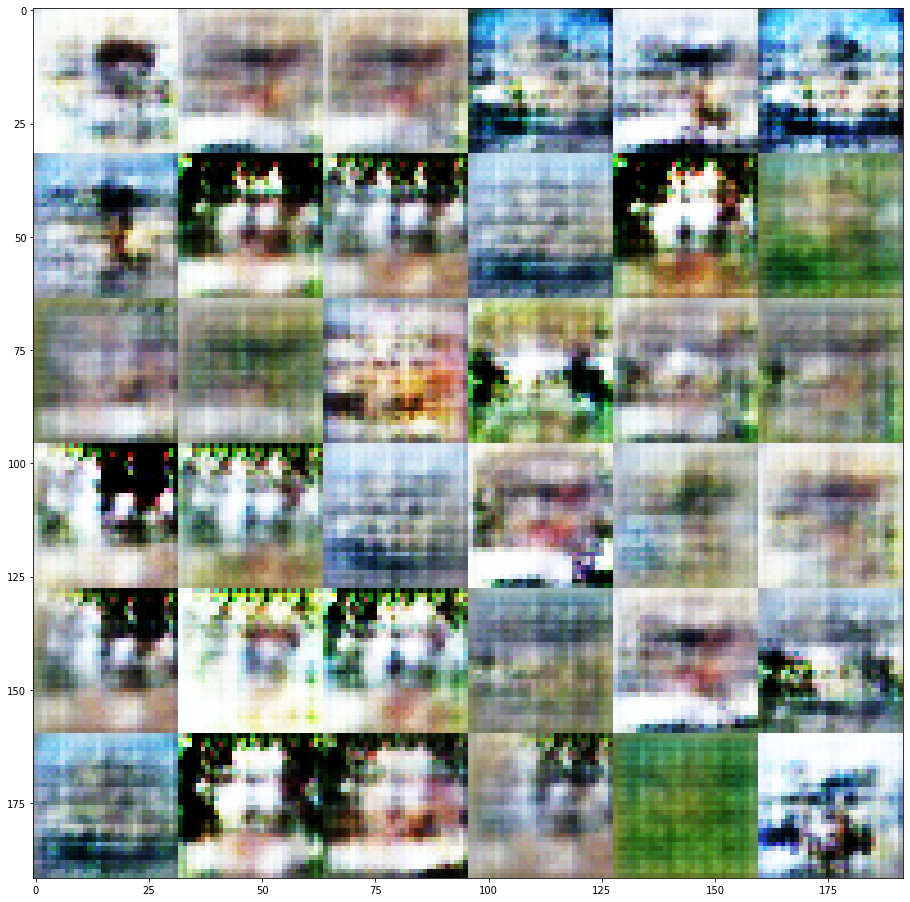

Epoch 40
	Plotting images and losses


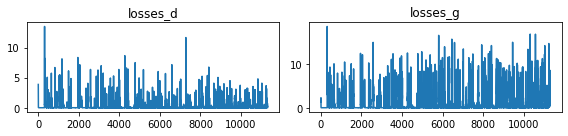

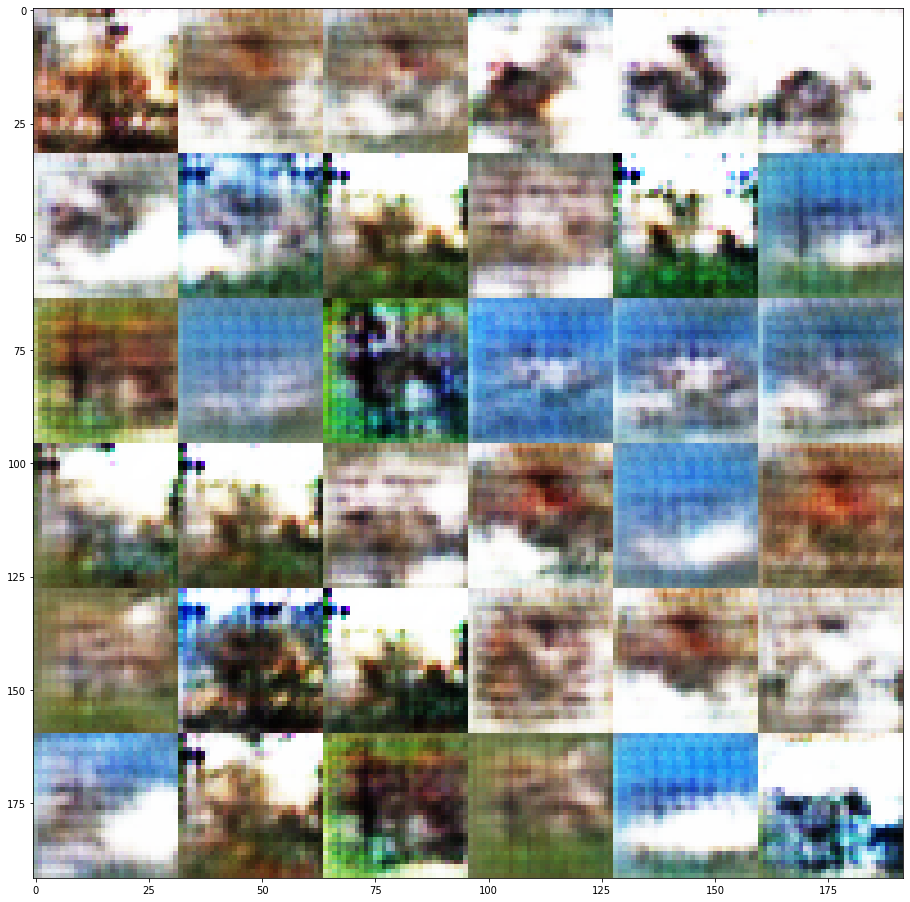

Epoch 50
	Plotting images and losses


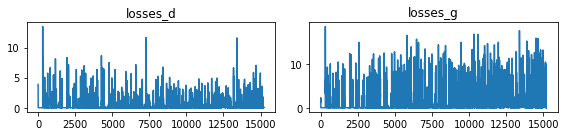

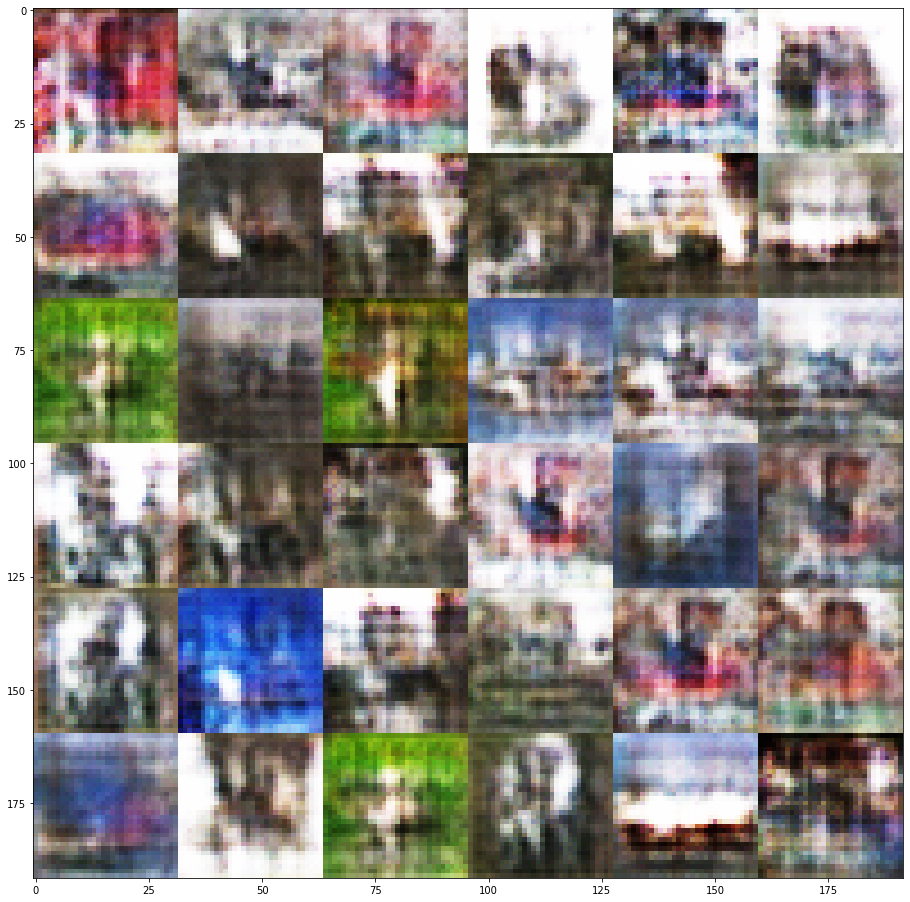

Epoch 60
	Plotting images and losses


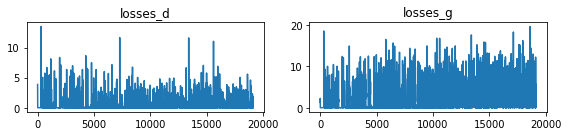

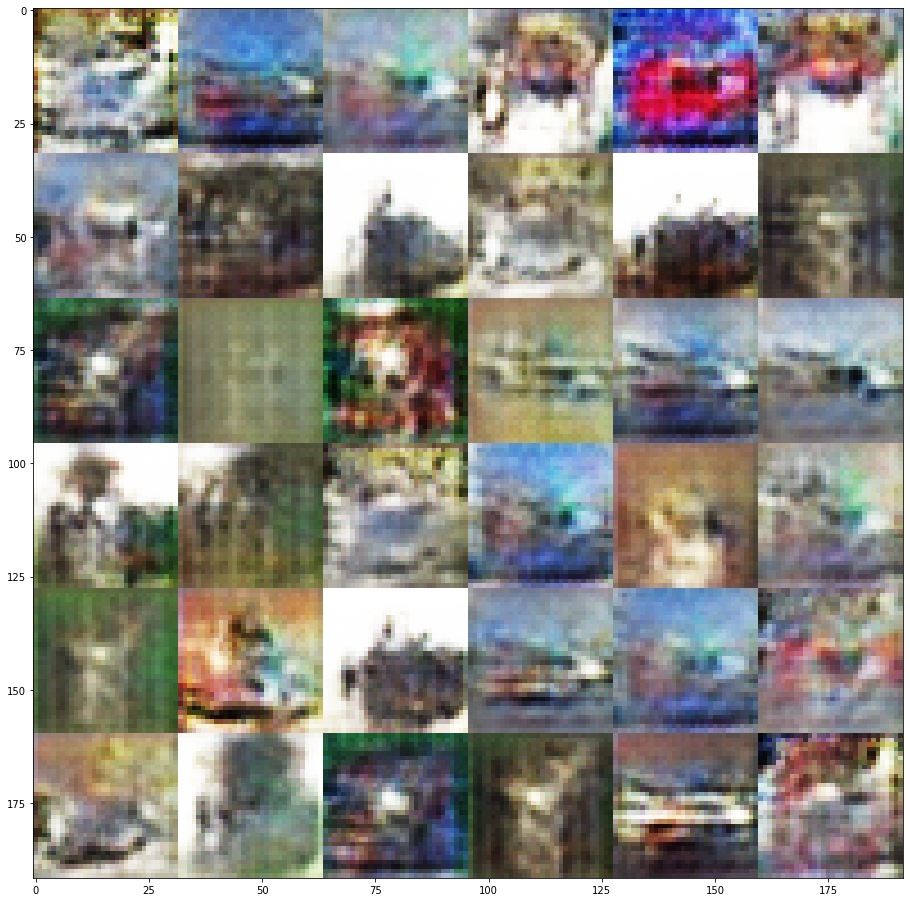

Epoch 70
	Plotting images and losses


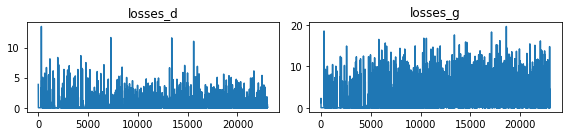

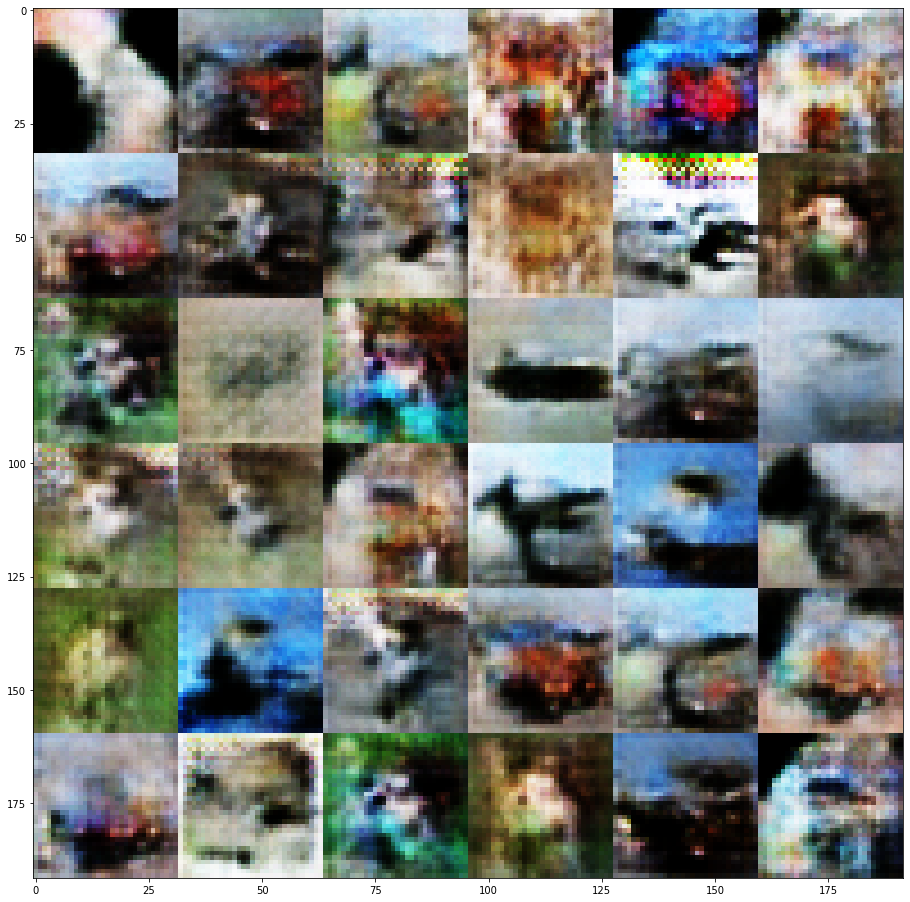

Epoch 80
	Plotting images and losses


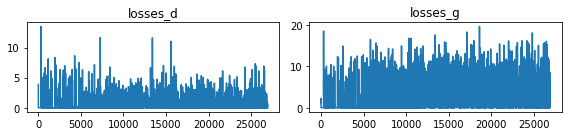

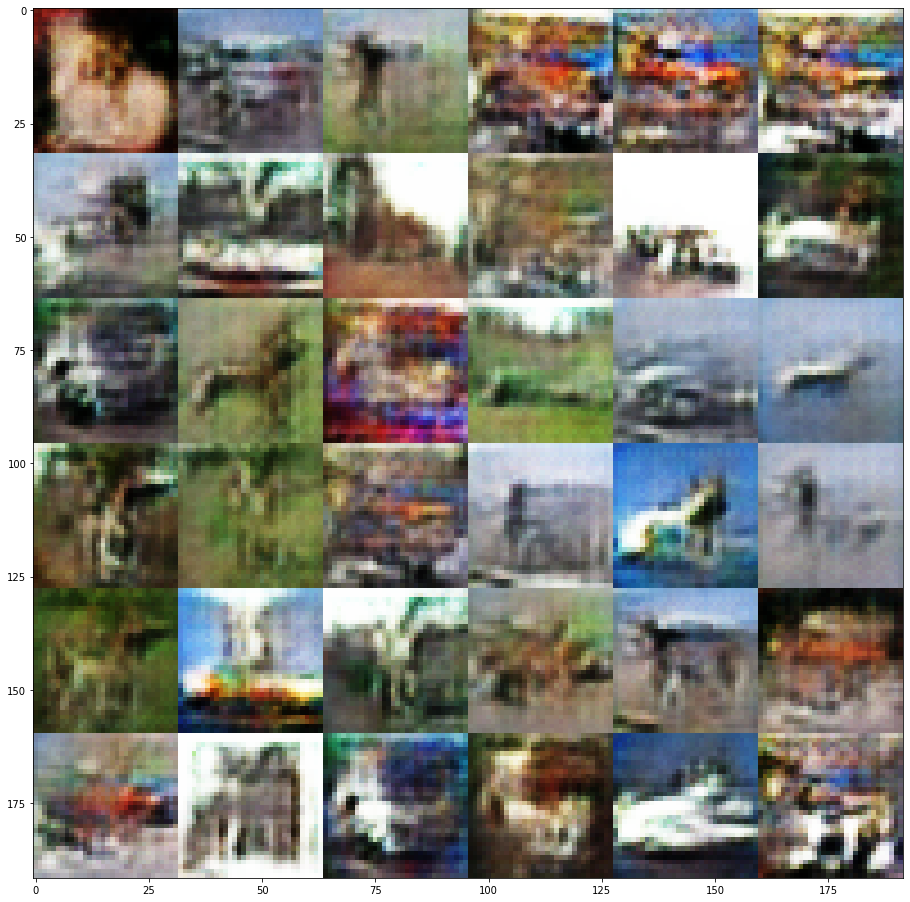

Epoch 90
	Plotting images and losses


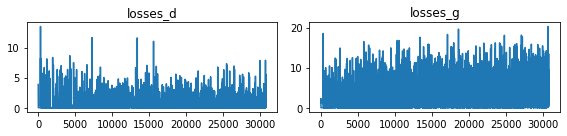

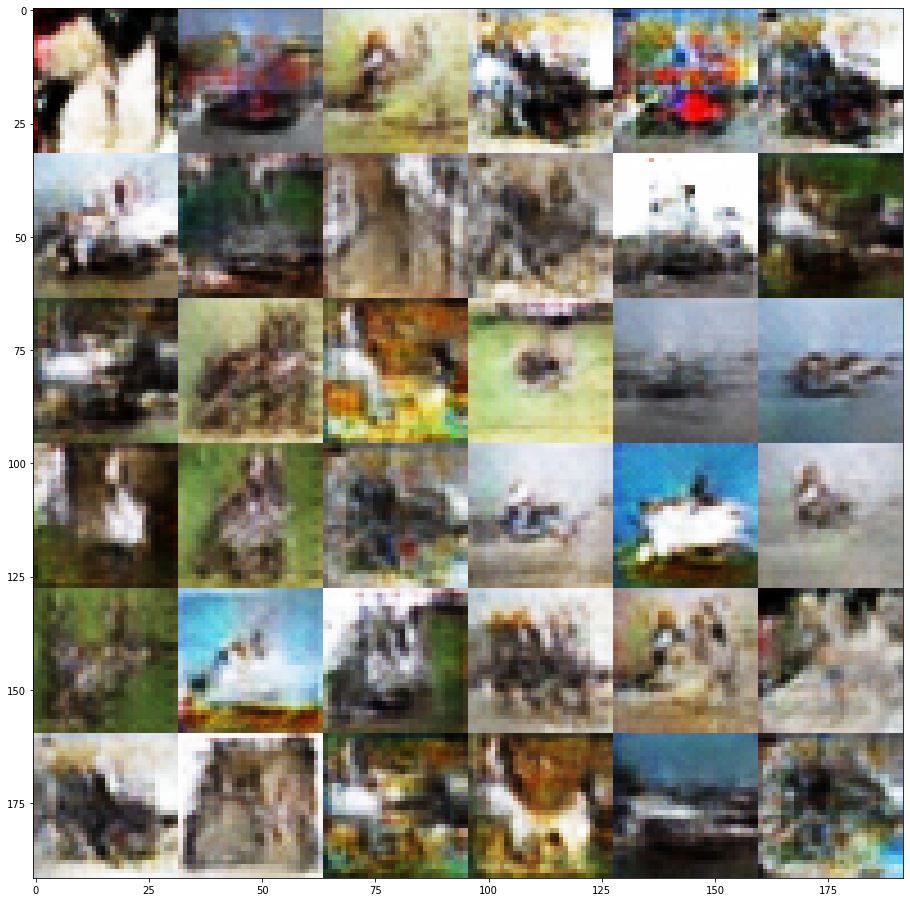

Epoch 100
	Plotting images and losses


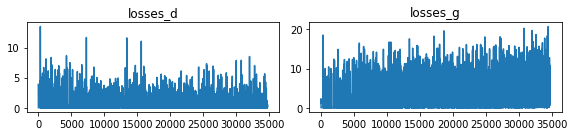

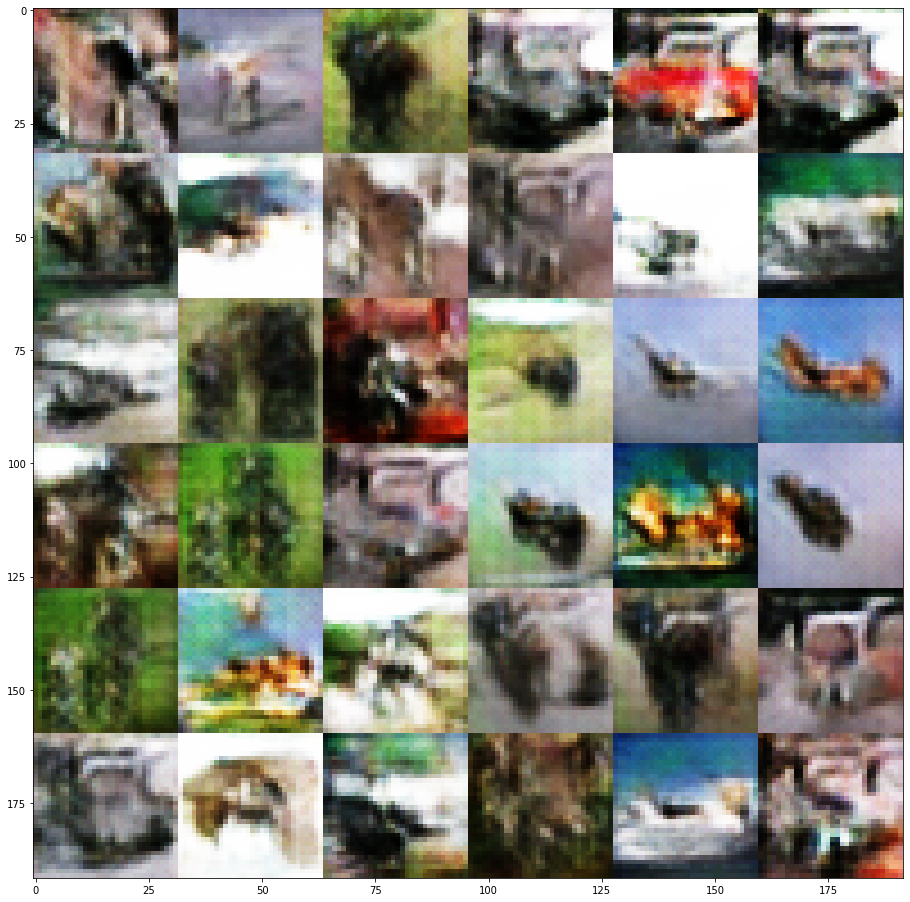

Epoch 110
	Plotting images and losses


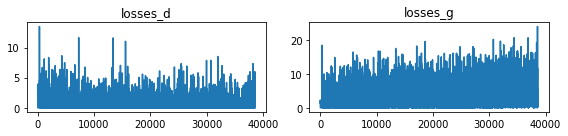

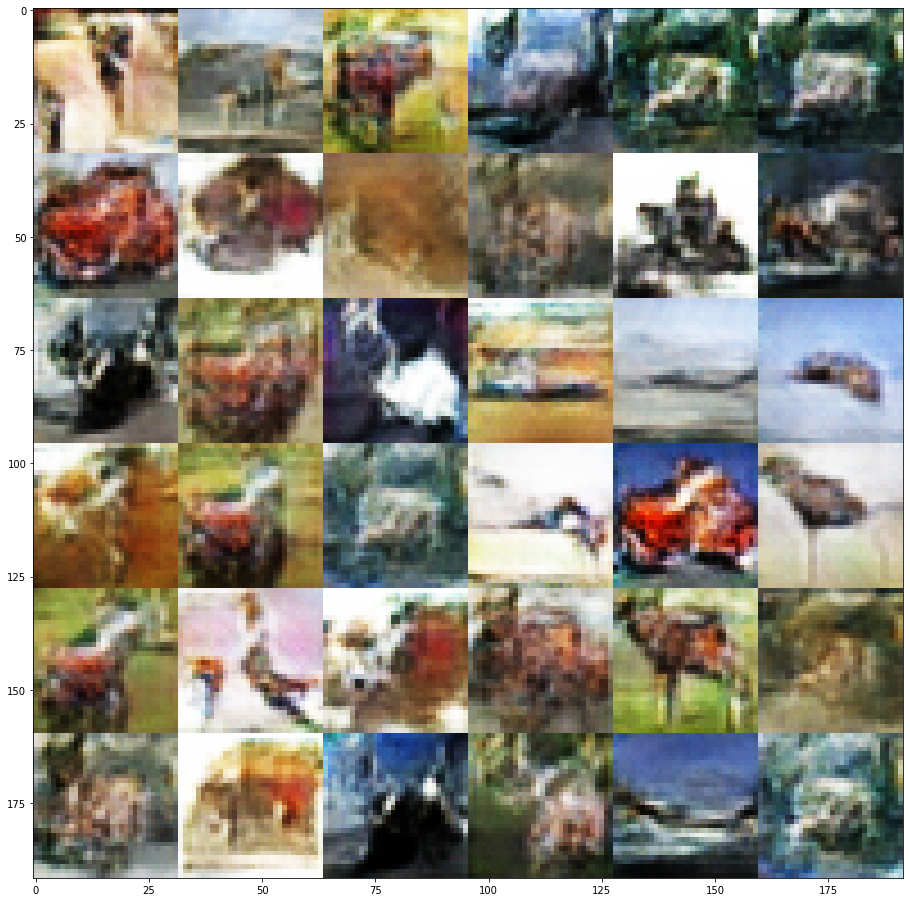

Epoch 120
	Plotting images and losses


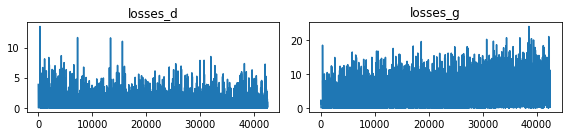

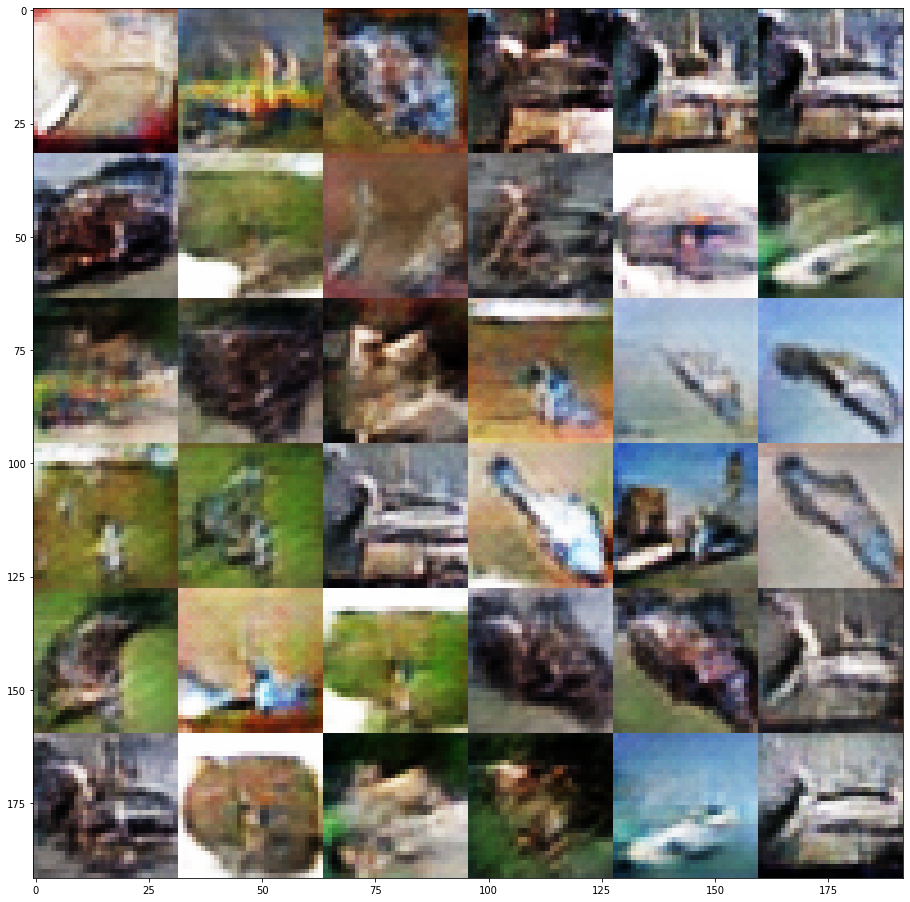

Epoch 130
	Plotting images and losses


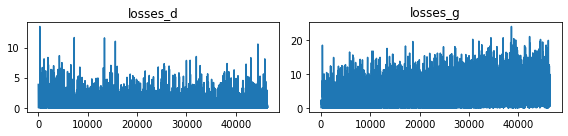

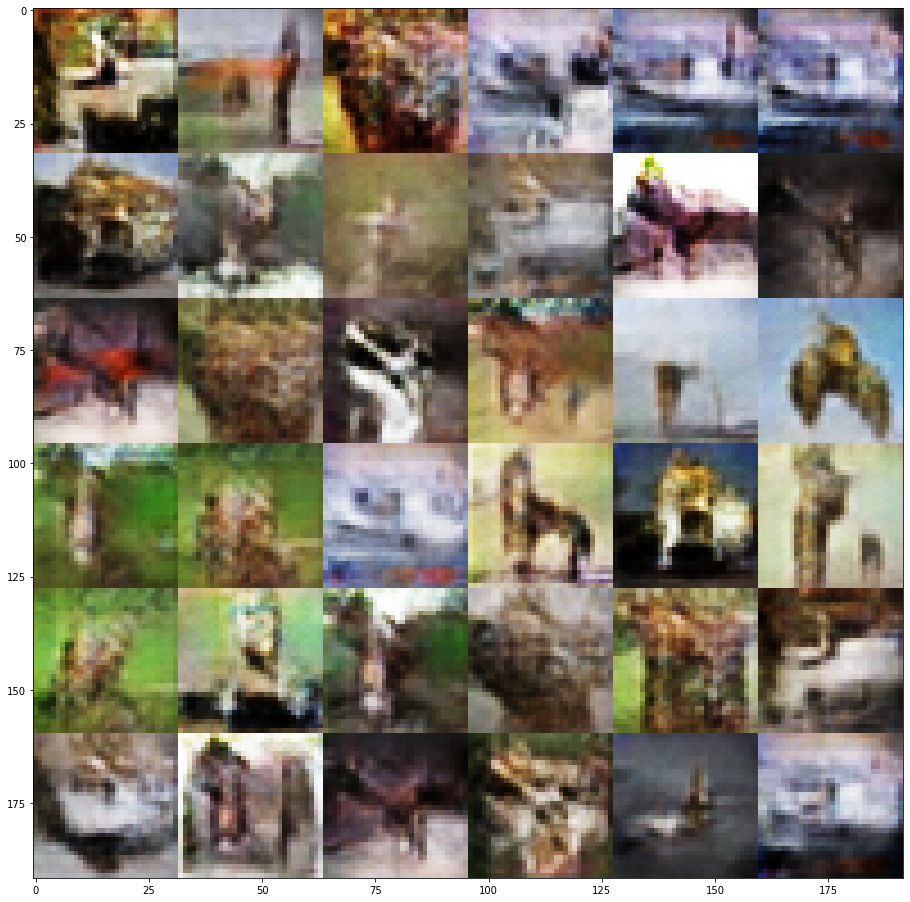

Epoch 140
	Plotting images and losses


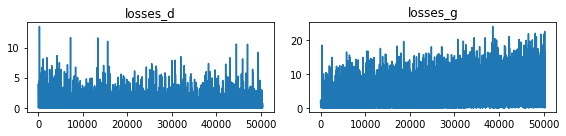

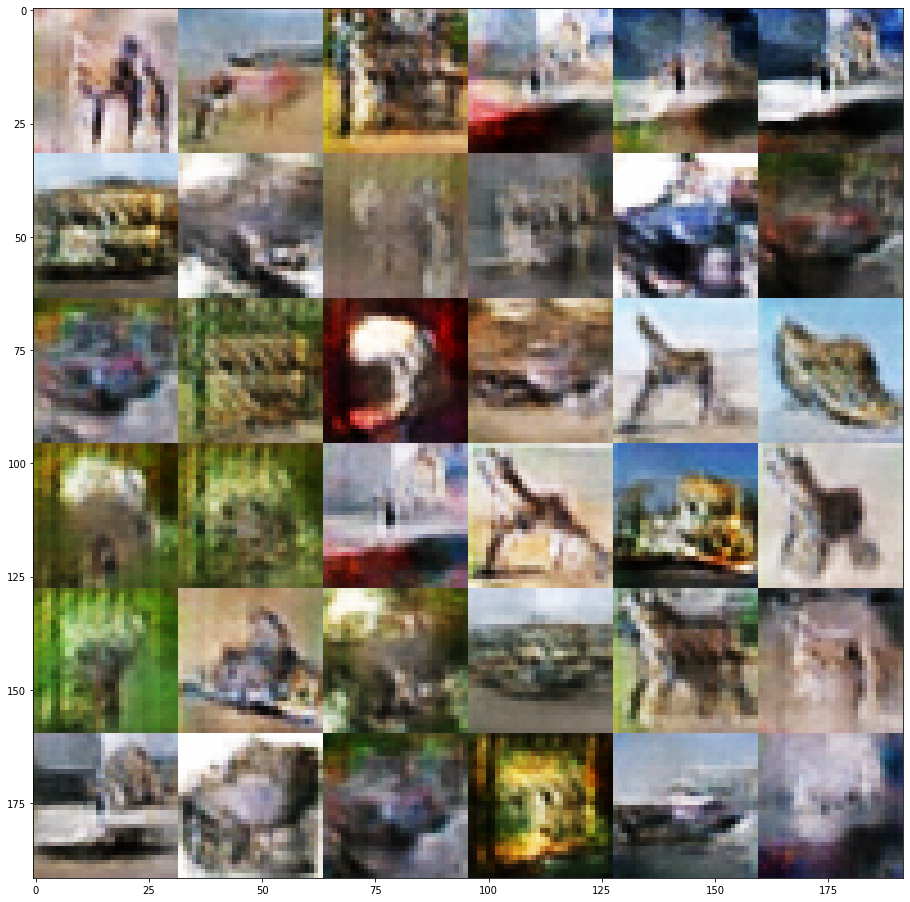

Epoch 150
	Plotting images and losses


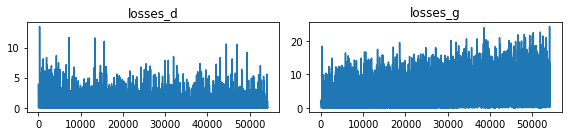

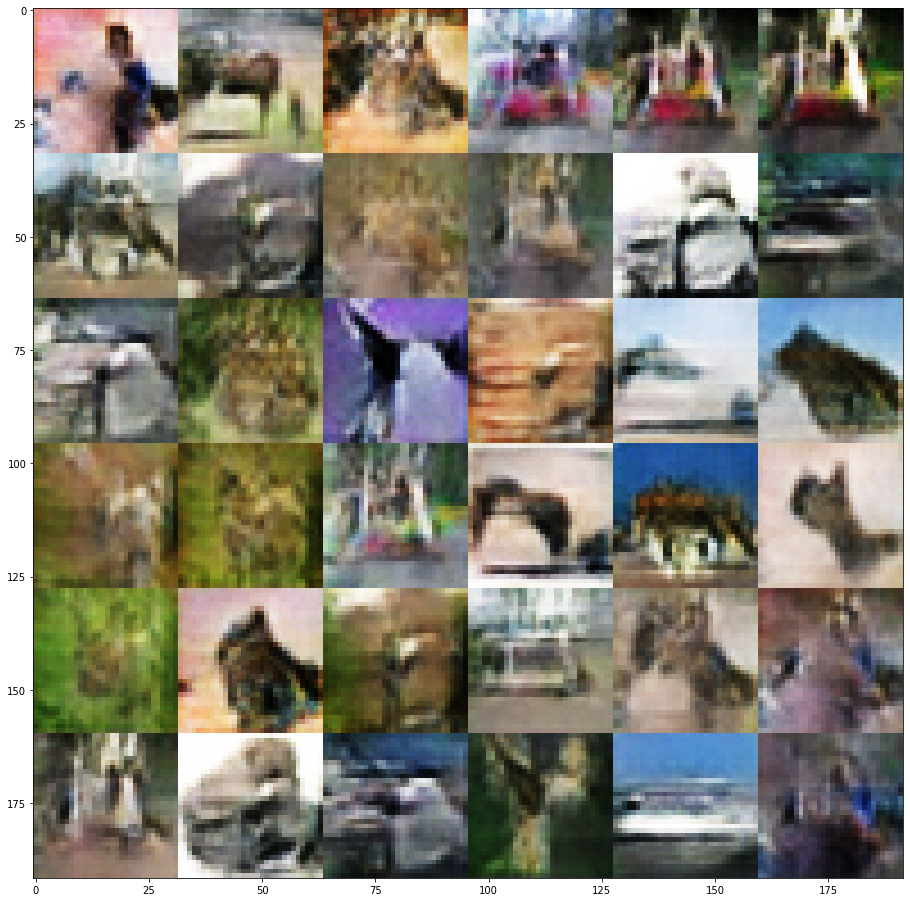

Epoch 160
	Plotting images and losses


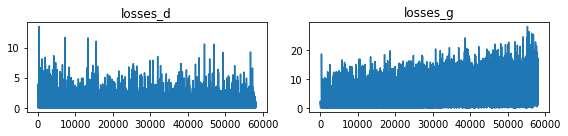

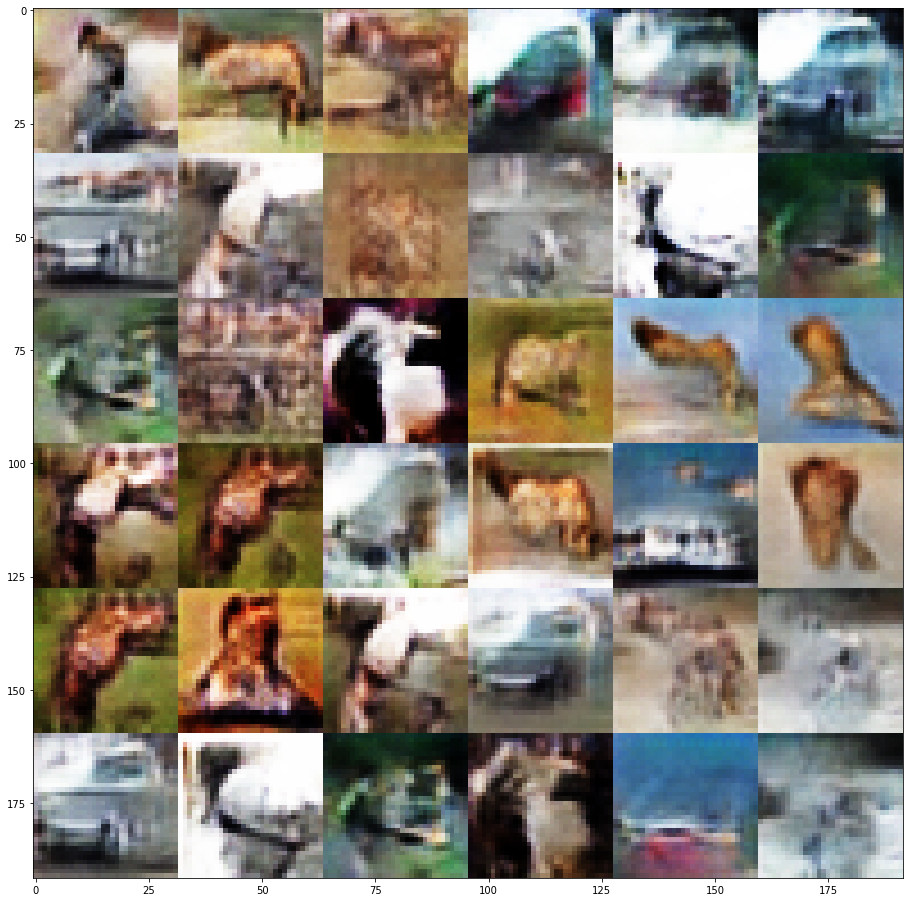

Epoch 170
	Plotting images and losses


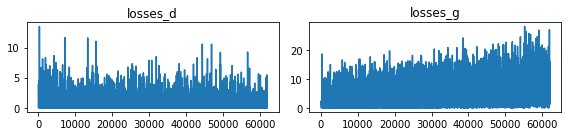

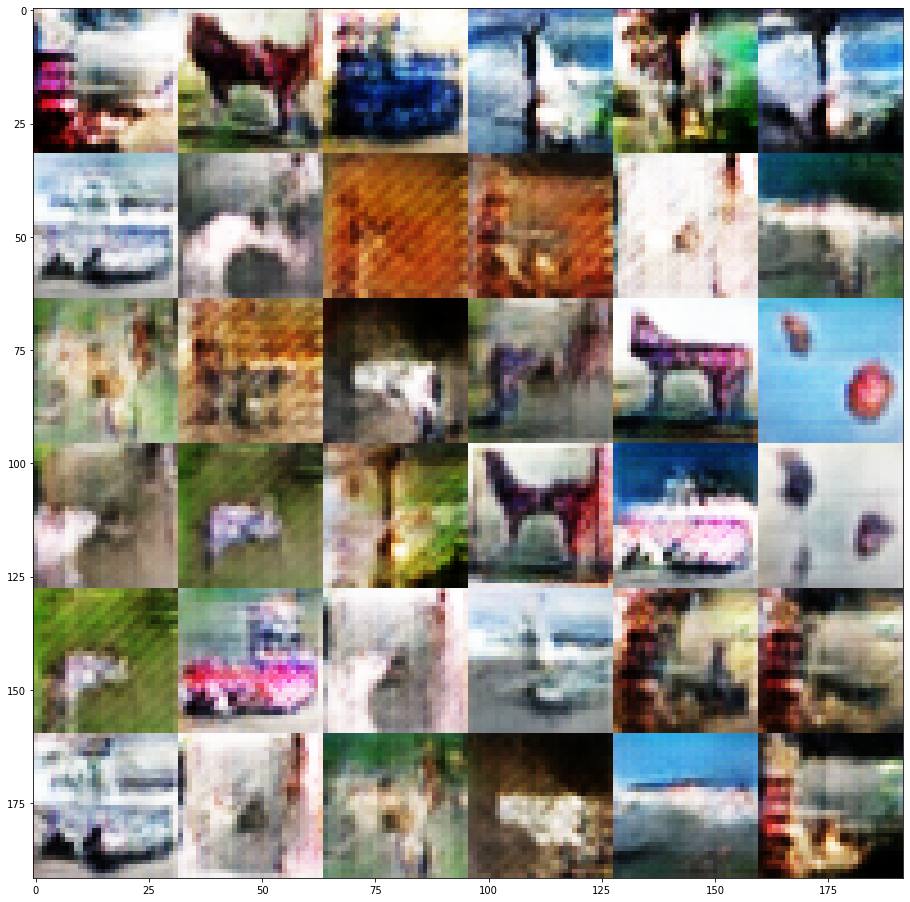

Epoch 180
	Plotting images and losses


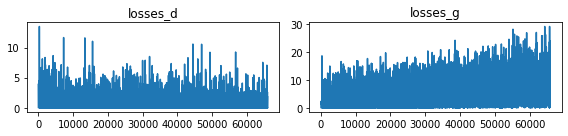

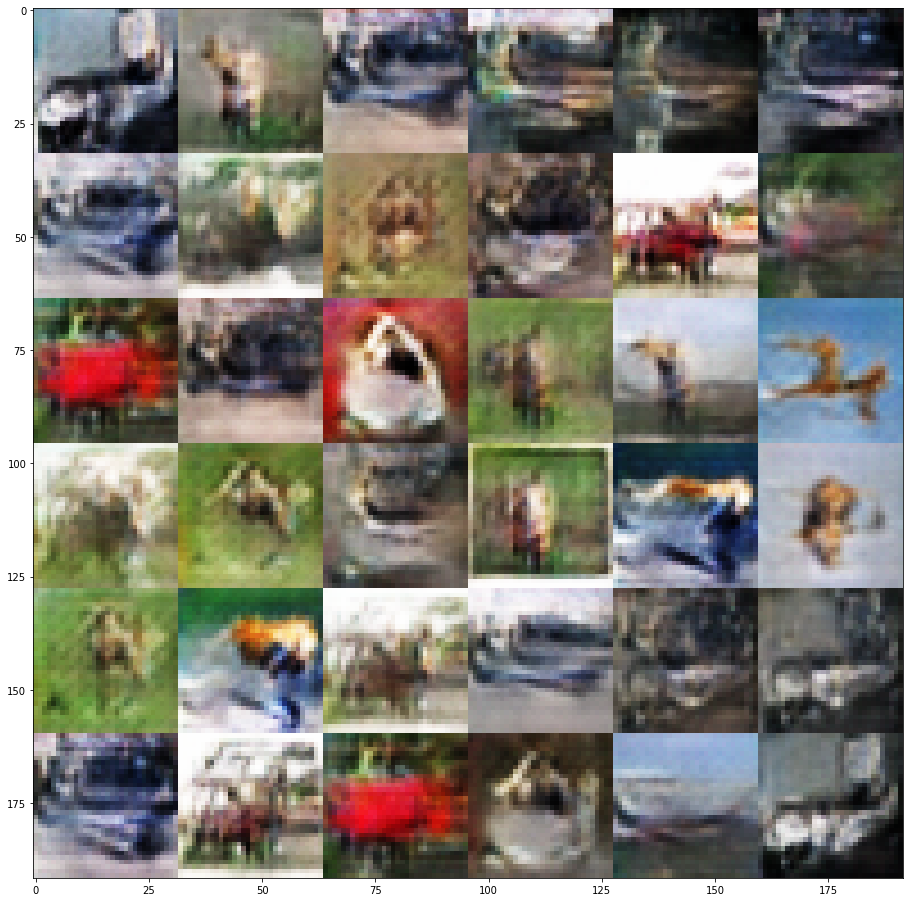

Epoch 190
	Plotting images and losses


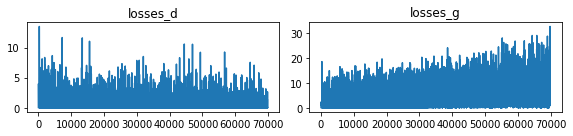

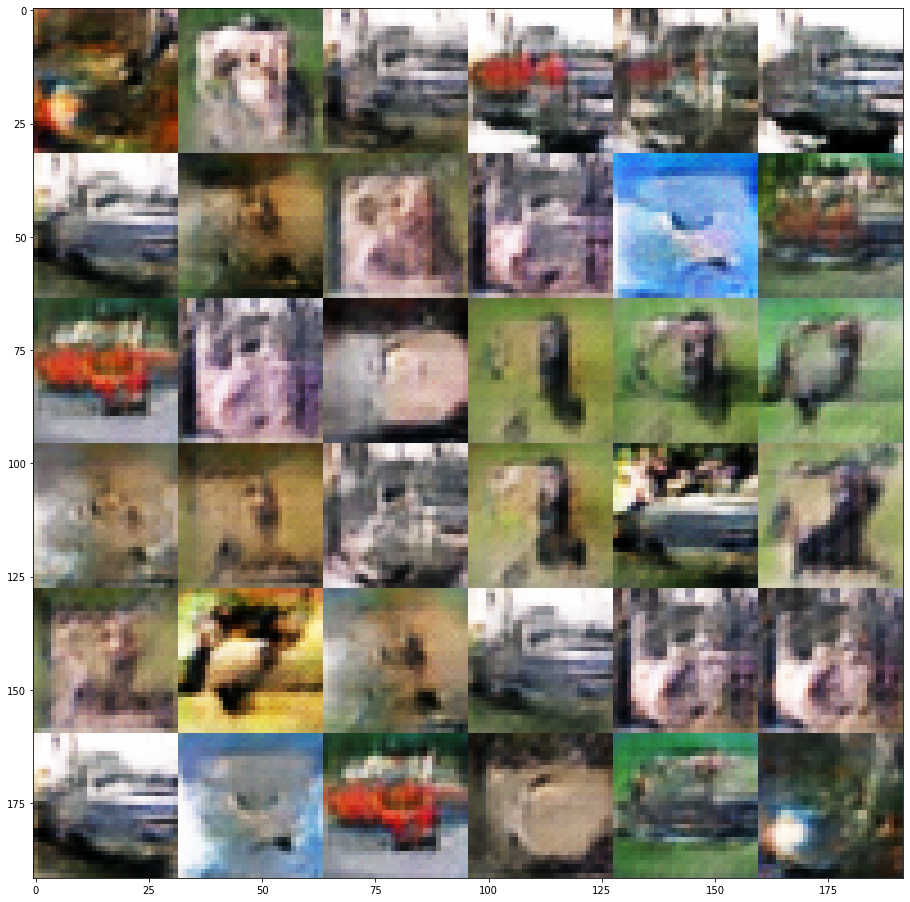

Epoch 200
	Plotting images and losses


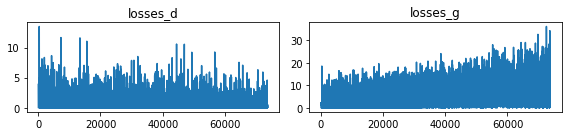

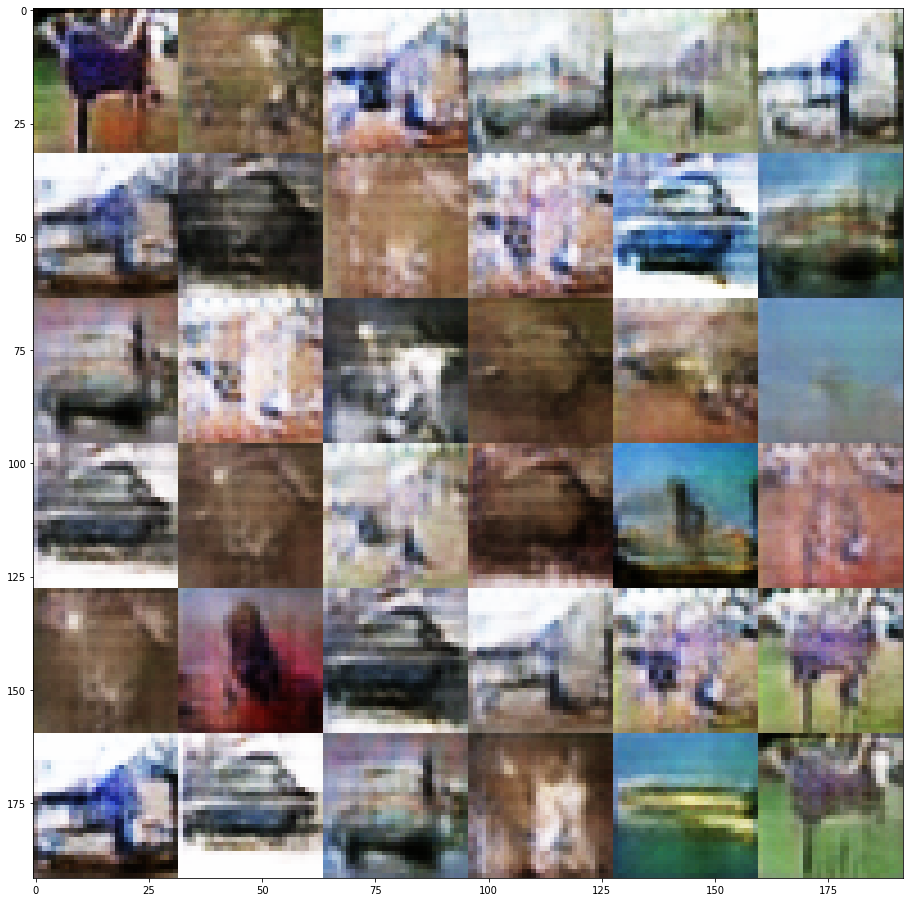

Epoch 210
	Plotting images and losses


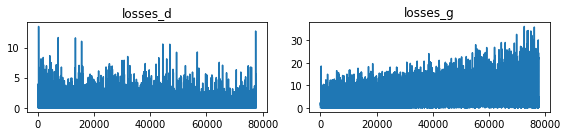

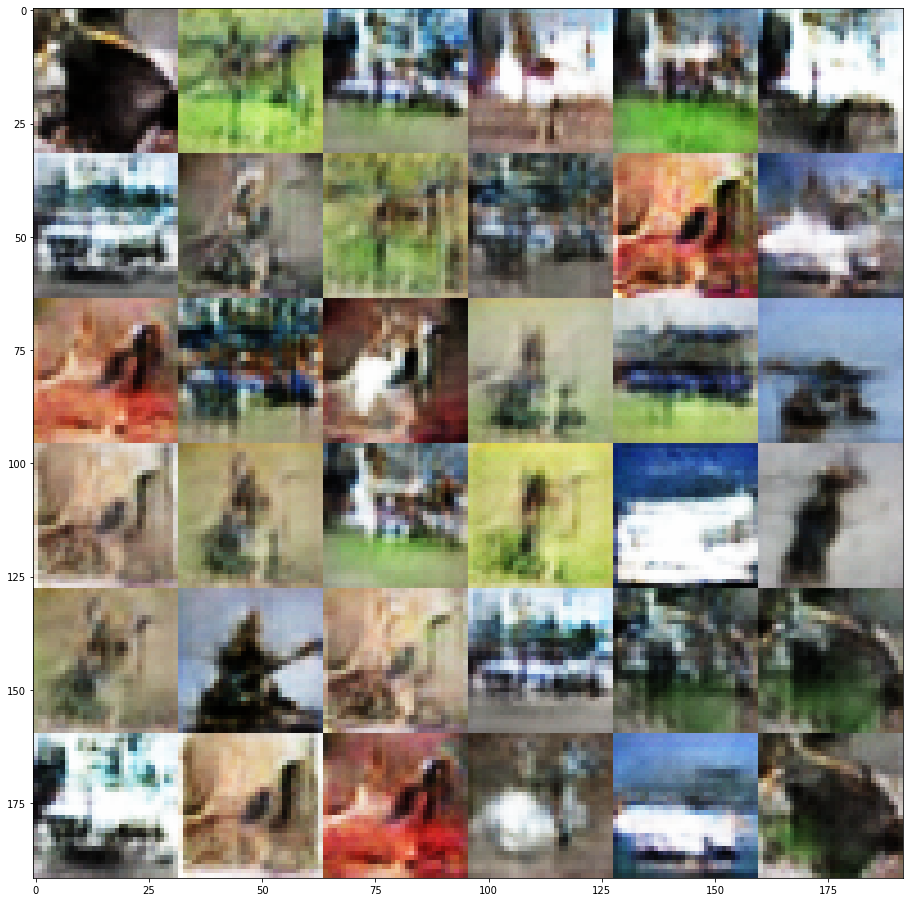

Epoch 220
	Plotting images and losses


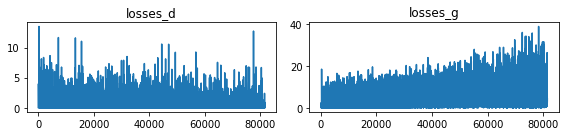

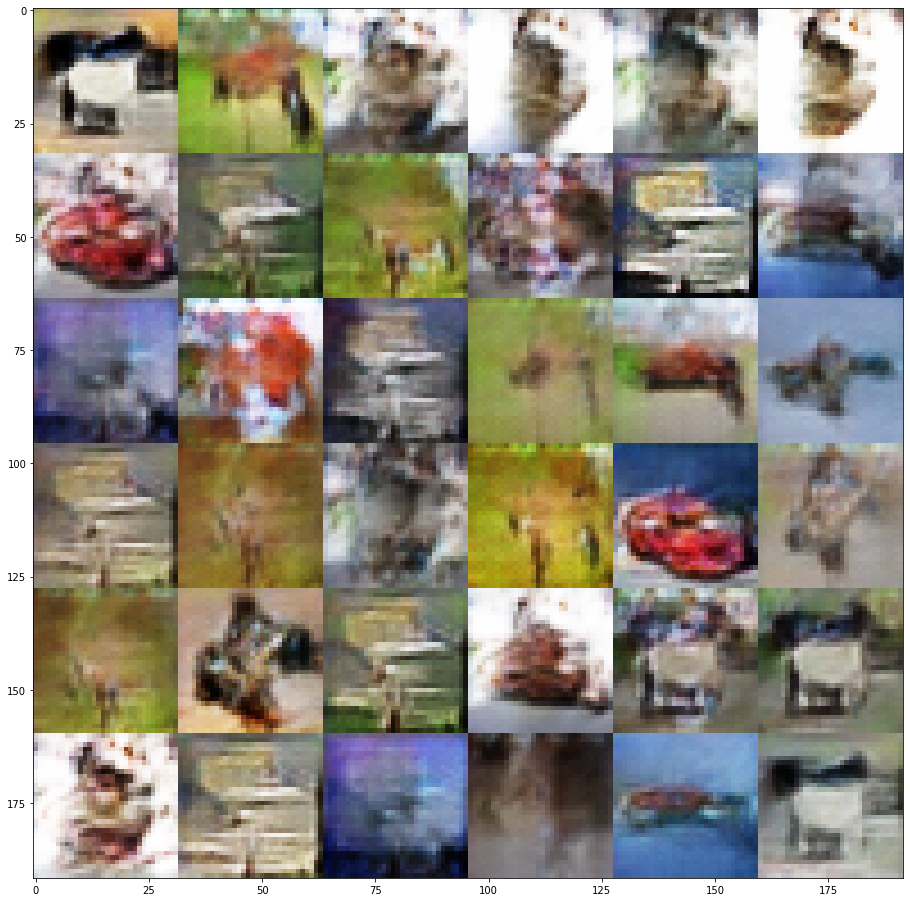

Epoch 230
	Plotting images and losses


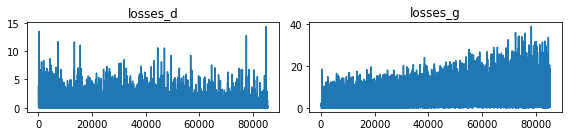

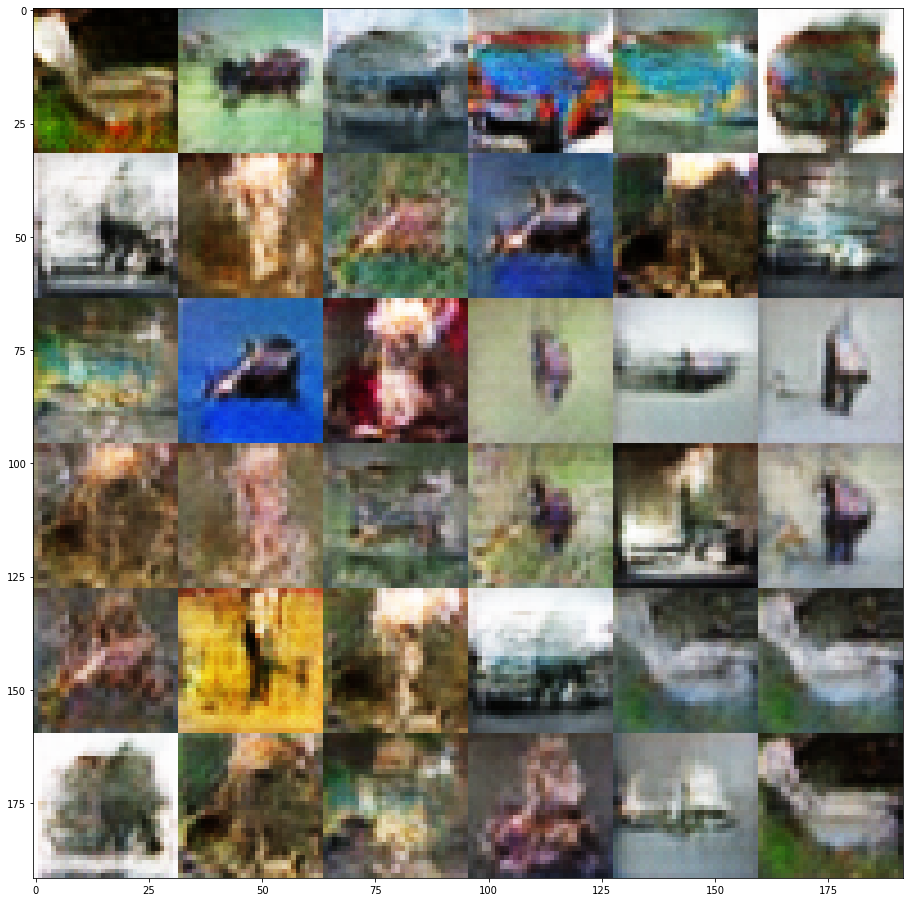

Epoch 240
	Plotting images and losses


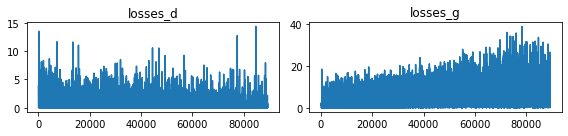

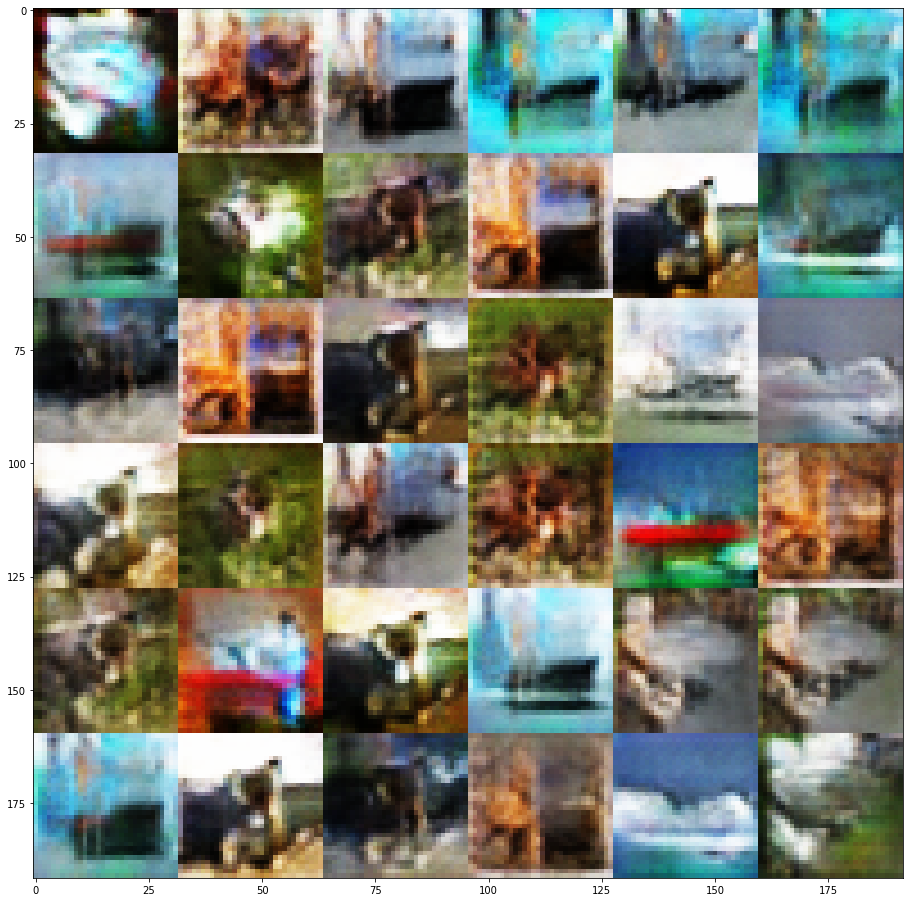

Epoch 250
	Plotting images and losses


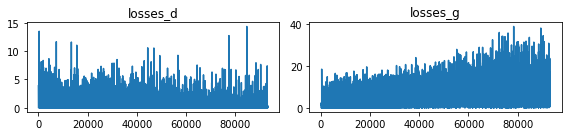

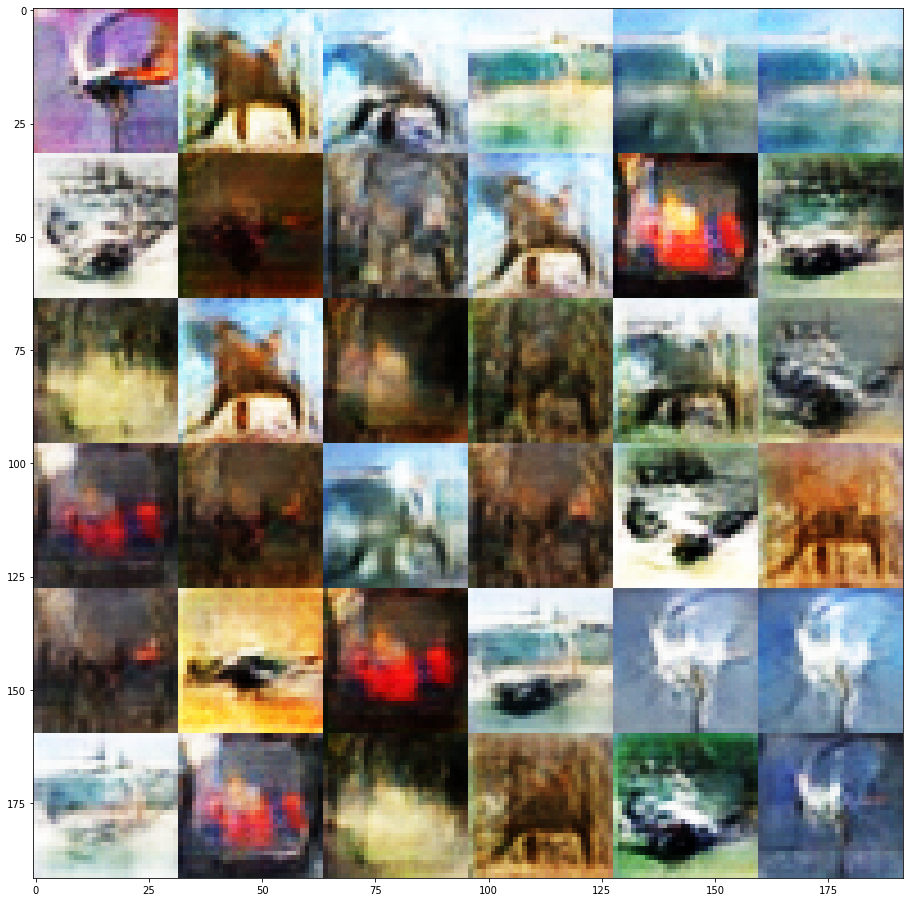

Epoch 260
	Plotting images and losses


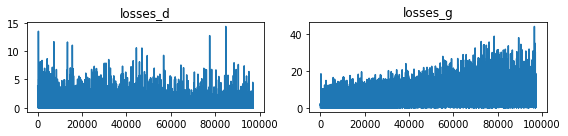

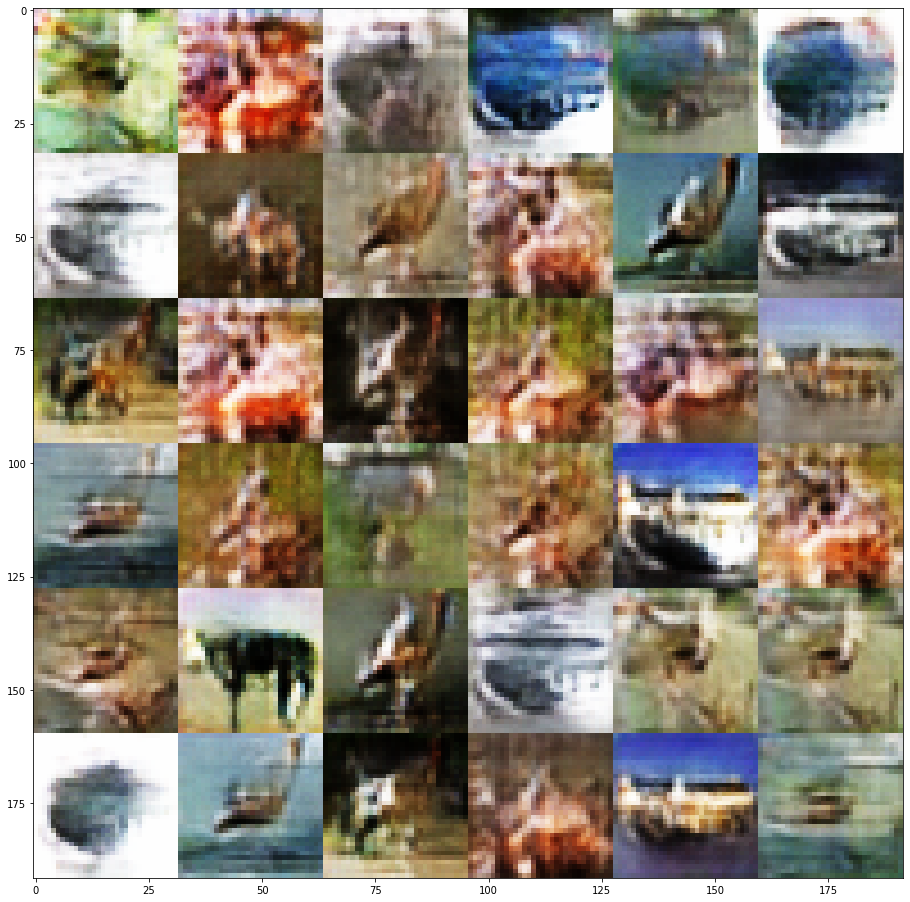

Epoch 270
	Plotting images and losses


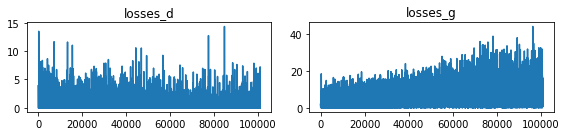

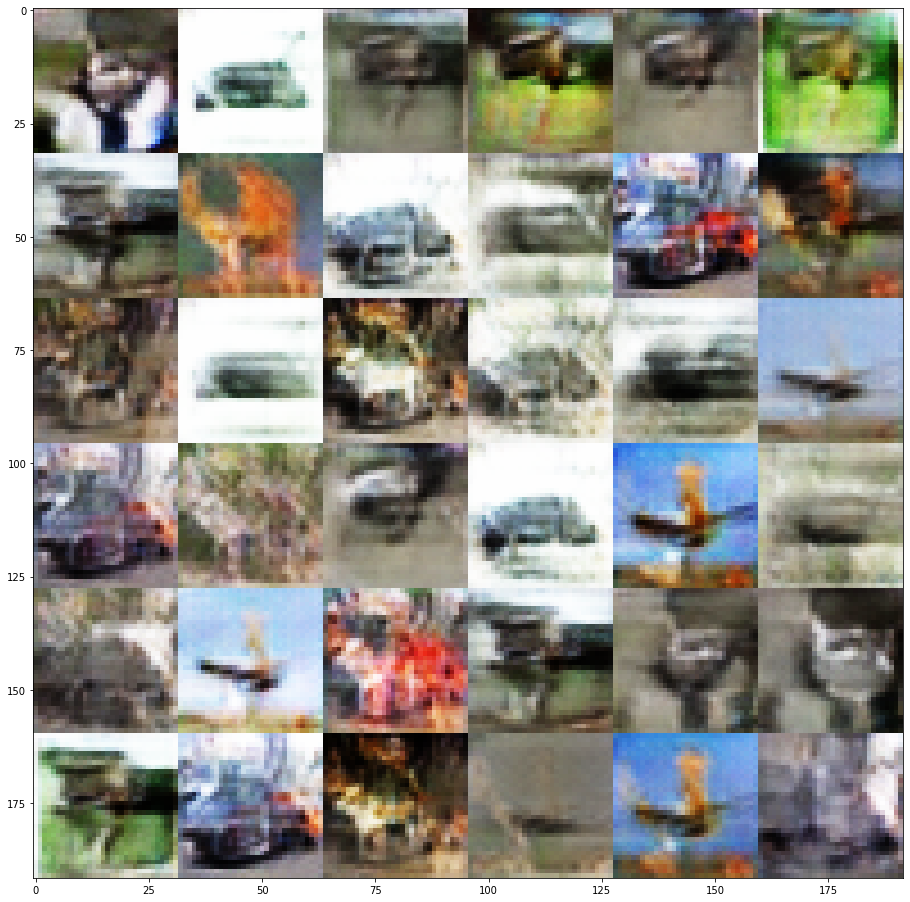

Epoch 280
	Plotting images and losses


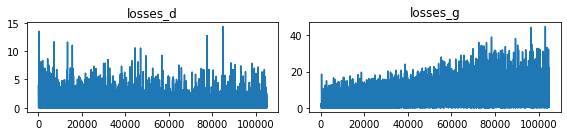

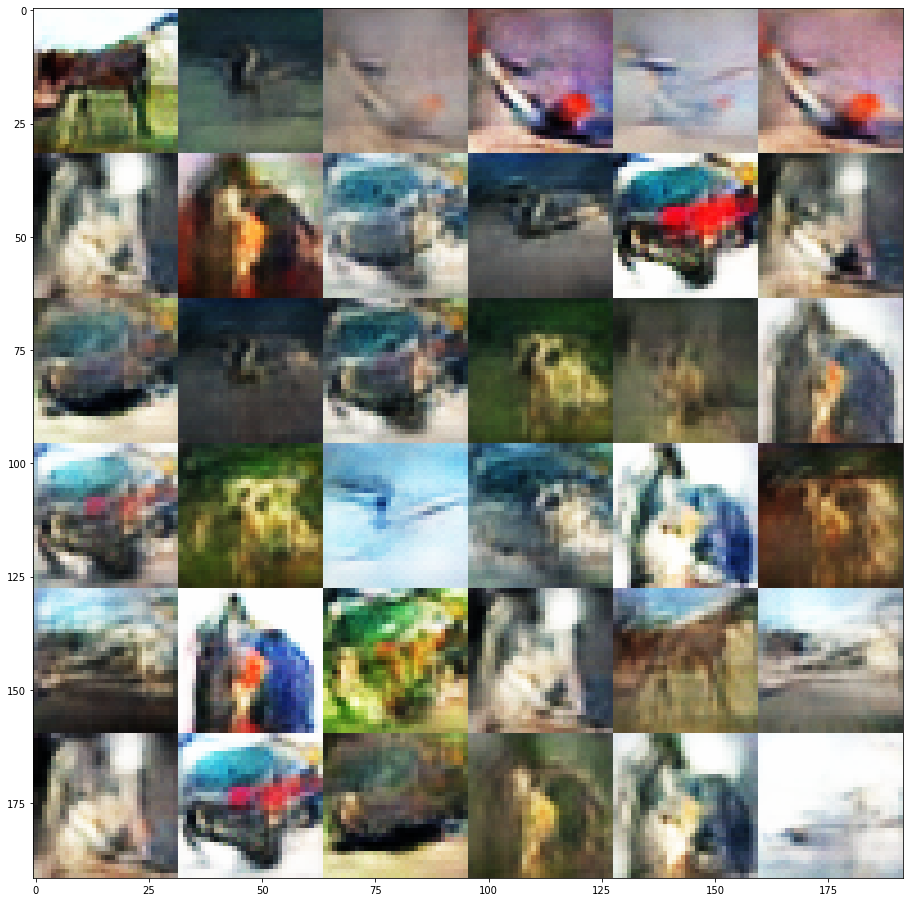

Epoch 290
	Plotting images and losses


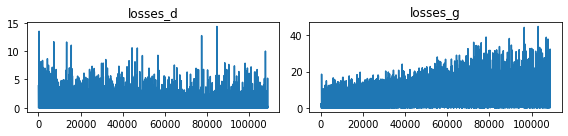

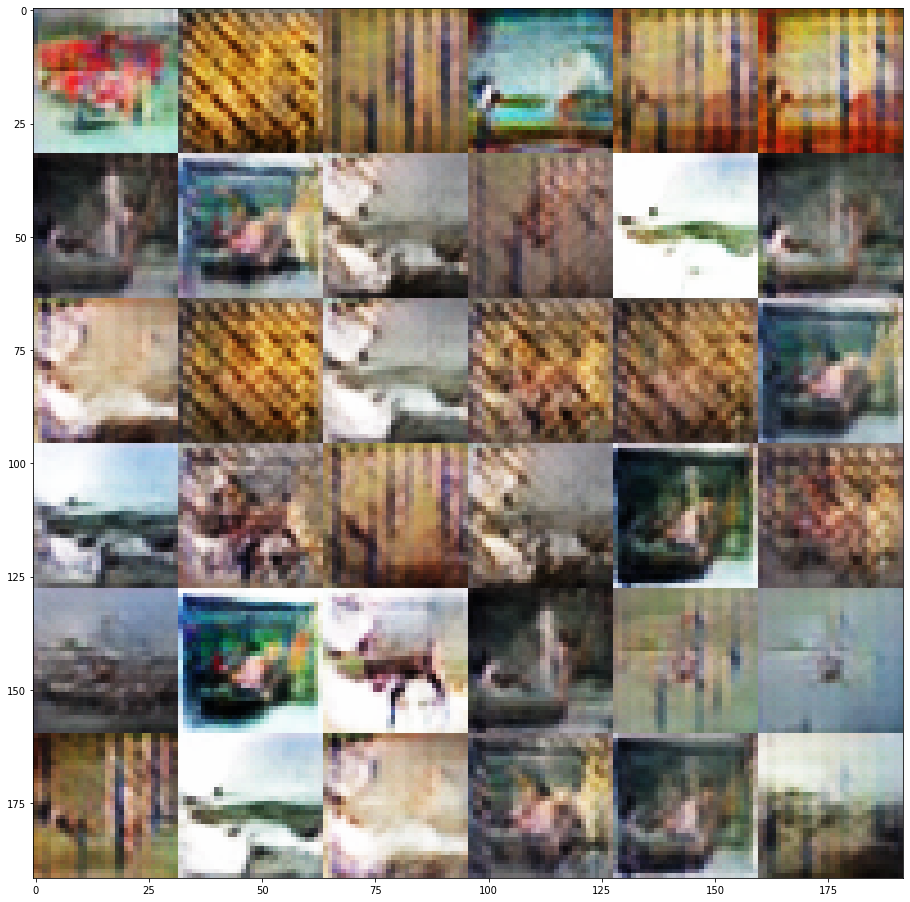

Epoch 300
	Plotting images and losses


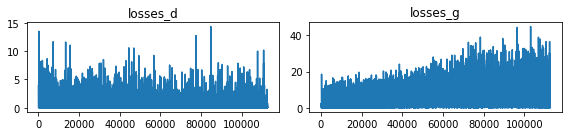

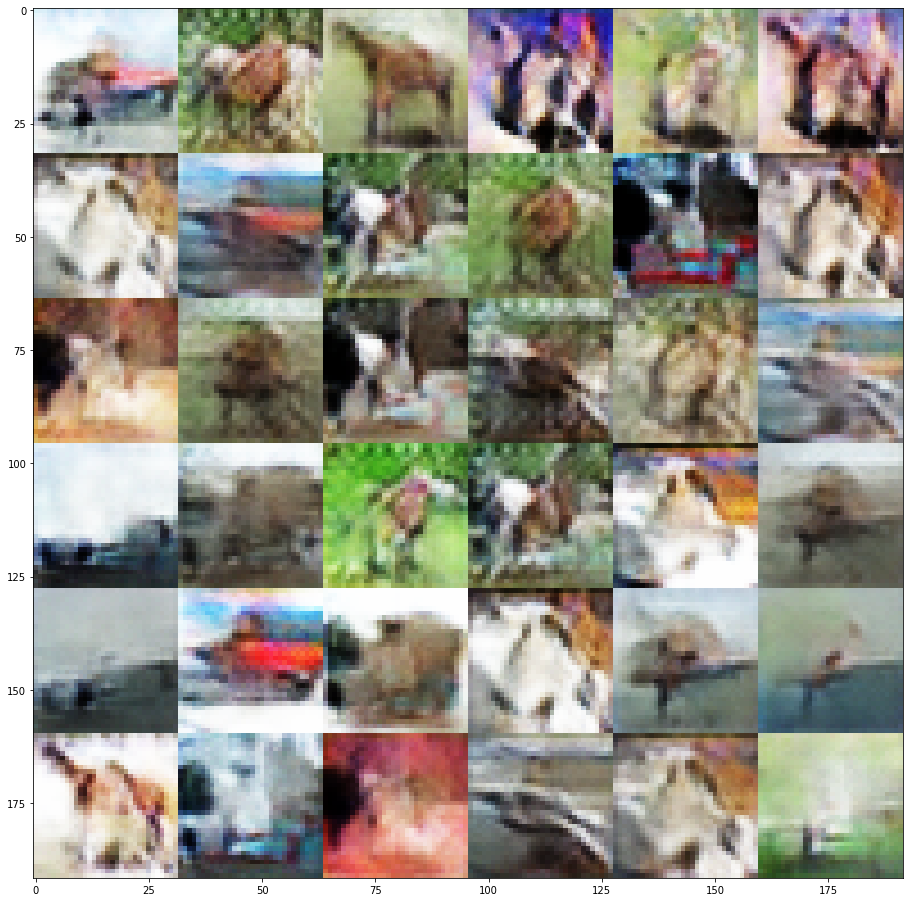

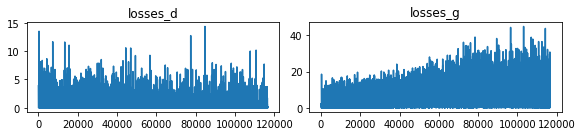

In [10]:
train()